**Connecting to Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import TensorFlow and Image Preprocessing Tools**

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Data Augmentation for Training Images**



In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

**Load Training Dataset from Directory**

In [4]:
train_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/Chest_Xray/chest_xray/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


**Load Test Dataset (Evaluation Only)**

In [3]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_set= test_datagen.flow_from_directory(r'/content/drive/MyDrive/Chest_Xray/chest_xray/test',
                                           target_size=(150,150),
                                           batch_size=32,
                                           class_mode='binary')

Found 624 images belonging to 2 classes.


**Model Architecture: MobileNetV2 + Custom Layers**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load base model without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


/tmp/ipython-input-327623547.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Model Training and Saving Best Weights**

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("mobilenetv2_pneumonia.h5", save_best_only=True)

# Train
history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=25,
    callbacks=[early_stopping, checkpoint]
)
from google.colab import files
files.download("mobilenetv2_pneumonia.h5")


Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.8098 - loss: 0.4265

163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 627ms/step - accuracy: 0.8098 - loss: 0.4264 - val_accuracy: 0.8189 - val_loss: 0.4024
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.8326 - loss: 0.3745

163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.8326 - loss: 0.3744 - val_accuracy: 0.8333 - val_loss: 0.3841
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.8596 - loss: 0.3416

163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 578ms/step - accuracy: 0.8596 - loss: 0.3417 - val_accuracy: 0.8365 - val_loss: 0.3707
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 587ms/step - accuracy: 0.8527 - loss: 0.3262 - val_accuracy: 0.8237 - val_loss: 0.3778
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8675 - loss: 0.3060

163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 575ms/step - accuracy: 0.8675 - loss: 0.3060 - val_accuracy: 0.8446 - val_loss: 0.3528
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8808 - loss: 0.2847

163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 587ms/step - accuracy: 0.8808 - loss: 0.2847 - val_accuracy: 0.8478 - val_loss: 0.3449
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8753 - loss: 0.2890

163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 577ms/step - accuracy: 0.8753 - loss: 0.2889 - val_accuracy: 0.8526 - val_loss: 0.3390
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 571ms/step - accuracy: 0.8716 - loss: 0.2914 - val_accuracy: 0.8494 - val_loss: 0.3396
Epoch 9/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 574ms/step - accuracy: 0.8804 - loss: 0.2576 - val_accuracy: 0.8494 - val_loss: 0.3412
Epoch 10/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.8758 - loss: 0.2744

163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 583ms/step - accuracy: 0.8759 - loss: 0.2744 - val_accuracy: 0.8606 - val_loss: 0.3319
Epoch 11/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 574ms/step - accuracy: 0.8839 - loss: 0.2702 - val_accuracy: 0.8494 - val_loss: 0.3324
Epoch 12/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.8930 - loss: 0.2652

163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 597ms/step - accuracy: 0.8930 - loss: 0.2652 - val_accuracy: 0.8606 - val_loss: 0.3284
Epoch 13/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 588ms/step - accuracy: 0.8819 - loss: 0.2689 - val_accuracy: 0.8606 - val_loss: 0.3352
Epoch 14/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 571ms/step - accuracy: 0.8874 - loss: 0.2608 - val_accuracy: 0.8574 - val_loss: 0.3313
Epoch 15/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 576ms/step - accuracy: 0.8879 - loss: 0.2547 - val_accuracy: 0.8574 - val_loss: 0.3353
Epoch 16/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 568ms/step - accuracy: 0.8980 - loss: 0.2398 - val_accuracy: 0.8542 - val_loss: 0.3296
Epoch 17/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 592ms/step - accuracy: 0.8995 - loss: 0.2460 - val_accuracy: 0.8542 - val_loss: 0.3363


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Plot Training & Validation Accuracy and Loss**

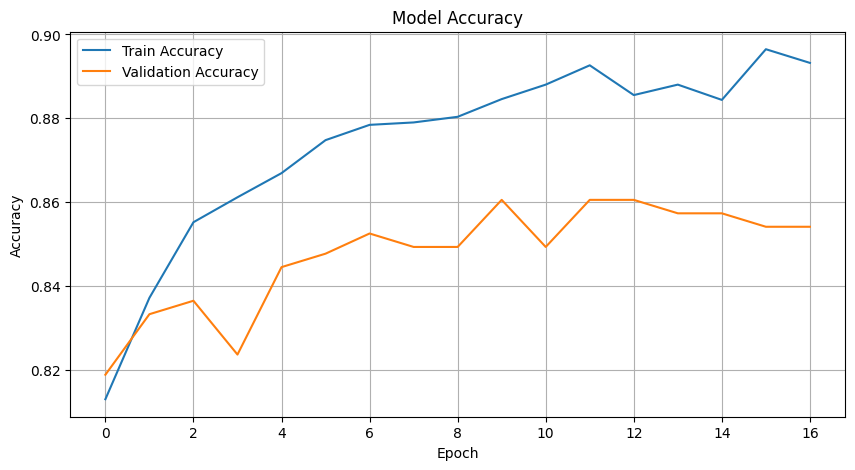

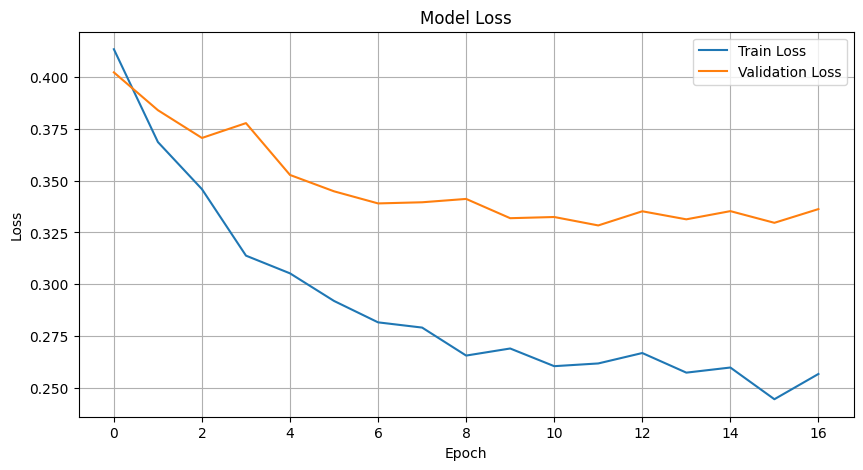

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


**Loading the Model**

In [15]:
from tensorflow.keras.models import load_model

model = load_model("/content/mobilenetv2_pneumonia.h5")


In [16]:
loss, acc = model.evaluate(test_set)
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 783ms/step - accuracy: 0.8658 - loss: 0.3163
Test Accuracy: 86.06%
Test Loss: 0.3284


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
val_set = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Chest_Xray/chest_xray/val",
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary"
)

Found 16 images belonging to 2 classes.


In [ ]:
# Unfreeze last 20 layers
from tensorflow.keras.metrics import AUC, Precision, Recall
for layer in model.layers[-20:]:
    layer.trainable = True

# Re-compile with smaller LR
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Callbacks (redefine here)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    "mobilenetv2_pneumonia_finetuned.h5",
    monitor="val_accuracy",   # save best accuracy model
    save_best_only=True,
    verbose=1
)

# Retrain (fine-tune)
history_finetune = model.fit(
    train_set,
    validation_data=val_set,
    epochs=30,
    callbacks=[early_stopping, checkpoint]

)
from google.colab import files
files.download("mobilenetv2_pneumonia_finetuned.h5")

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.8362 - auc: 0.9022 - loss: 0.3512 - precision: 0.8480 - recall: 0.9504 
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to mobilenetv2_pneumonia_finetuned.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 4039s 25s/step - accuracy: 0.8364 - auc: 0.9023 - loss: 0.3510 - precision: 0.8482 - recall: 0.9503 - val_accuracy: 0.7500 - val_auc: 0.9062 - val_loss: 0.7629 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8948 - auc: 0.9487 - loss: 0.2522 - precision: 0.9268 - recall: 0.9310
Epoch 2: val_accuracy did not improve from 0.75000
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 554ms/step - accuracy: 0.8948 - auc: 0.9486 - loss: 0.2522 - precision: 0.9269 - recall: 0.9310 - val_accuracy: 0.6875 - val_auc: 0.9219 - val_loss: 0.7971 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.8956 - auc: 0.9514 - loss: 0.2467 - precision: 0.9232 - recall: 0.9355
Epoch 3: val_accuracy did not improve from 0.75000
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 552ms/step - accuracy: 0.8957 - auc: 0.9514 - loss: 0.2466 - precision: 0.9233 - recall: 0.9355 - val_accuracy: 0.6875

163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 551ms/step - accuracy: 0.9135 - auc: 0.9650 - loss: 0.2112 - precision: 0.9341 - recall: 0.9490 - val_accuracy: 0.8125 - val_auc: 1.0000 - val_loss: 0.4420 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9149 - auc: 0.9669 - loss: 0.1998 - precision: 0.9484 - recall: 0.9386
Epoch 8: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 548ms/step - accuracy: 0.9150 - auc: 0.9669 - loss: 0.1998 - precision: 0.9484 - recall: 0.9387 - val_accuracy: 0.8125 - val_auc: 0.9062 - val_loss: 0.6340 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.9266 - auc: 0.9729 - loss: 0.1851 - precision: 0.9529 - recall: 0.9474
Epoch 9: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 546ms/step - accuracy: 0.9266 - auc: 0.9729 - loss: 0.1852 - precision: 0.9529 - recall: 0.9474 - val_accuracy: 0.6875

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
from tensorflow.keras.models import load_model

model = load_model("/content/mobilenetv2_pneumonia_finetuned.h5")


In [10]:

results= model.evaluate(test_set)
print("Test Results:", results)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 191s 9s/step - accuracy: 0.8584 - auc: 0.9438 - loss: 0.3503 - precision: 0.8386 - recall: 0.9612
Test Results: [0.38171565532684326, 0.8413461446762085, 0.9393764734268188, 0.8197802305221558, 0.9564102292060852]


In [20]:
from PIL import Image
import numpy as np
import tensorflow as tf

# Load model
model = tf.keras.models.load_model("/content/mobilenetv2_pneumonia_finetuned.h5")

# Load image
image = Image.open("/content/test_image.png").resize((150, 150))  # Or 224x224 if your model used that
image = image.convert("RGB")  # Convert grayscale to RGB

# Preprocess
img_array = np.array(image) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print(f"Pneumonia Detected ({prediction[0][0]*100:.2f}% confidence)")
else:
    print(f"Normal Lung ({(1-prediction[0][0])*100:.2f}% confidence)")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Pneumonia Detected (99.94% confidence)


In [4]:
model = tf.keras.models.load_model("/content/mobilenetv2_pneumonia_finetuned.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 229s 12s/step


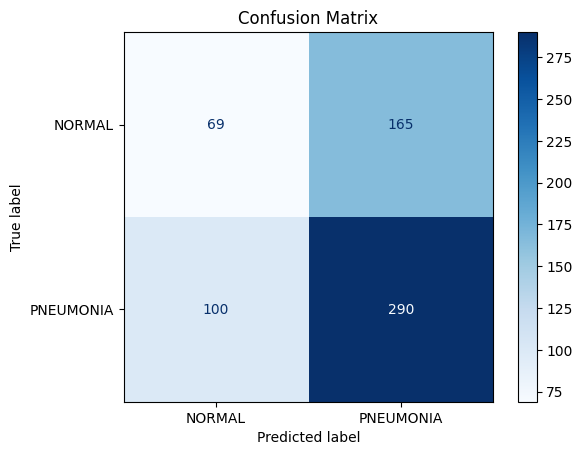

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions
y_true = test_set.classes
y_pred = (model.predict(test_set) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_set.class_indices.keys())
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
